In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv

import tensorflow as tf
from tensorflow import keras
from random import shuffle
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,Dropout,MaxPooling2D
from sklearn.model_selection import train_test_split

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import zipfile
zip_ref=zipfile.ZipFile('C:/Users/riyab/anacondas/MRI Detection/Brain Tumor Data Set.zip')
zip_ref.extractall('C:/Users/riyab/anacondas/MRI Detection/tumor-detection-mri')

In [21]:
tumor_dir='C:/Users/riyab/anacondas/MRI Detection/tumor-detection-mri/Brain Tumor Data Set/Brain Tumor'
healthy_dir='C:/Users/riyab/anacondas/MRI Detection/tumor-detection-mri/Brain Tumor Data Set/Healthy'

filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list): 
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  C:/Users/riyab/anacondas/MRI Detection/tumor-d...  cancer
1  C:/Users/riyab/anacondas/MRI Detection/tumor-d...  cancer
2  C:/Users/riyab/anacondas/MRI Detection/tumor-d...  cancer
3  C:/Users/riyab/anacondas/MRI Detection/tumor-d...  cancer
4  C:/Users/riyab/anacondas/MRI Detection/tumor-d...  cancer
cancer     2513
healthy    2087
Name: labels, dtype: int64


In [22]:
tumor_df.shape

(4600, 2)

In [24]:
train_images, test_images=train_test_split(tumor_df, test_size=0.3, random_state=42)
train_set, val_set=train_test_split(tumor_df, test_size=0.2, random_state=42)

In [25]:
print(train_set.shape)
print(val_set.shape)
print(train_images.shape)
print(test_images.shape)

(3680, 2)
(920, 2)
(3220, 2)
(1380, 2)


In [27]:
image_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
train=image_gen.flow_from_dataframe(dataframe=train_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

test=image_gen.flow_from_dataframe(dataframe=test_images, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)
val=image_gen.flow_from_dataframe(dataframe=val_set, x_col='filepaths',y_col='labels',
                                    target_size=(244,244),
                                    color_mode='rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False)

Found 3680 validated image filenames belonging to 2 classes.
Found 1380 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


In [28]:
classes=list(train.class_indices.keys())
print(classes)

['cancer', 'healthy']


In [29]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(10,10))
    length = len(labels)
    r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="blue",fontsize=16)
        plt.axis('off')
    plt.show()

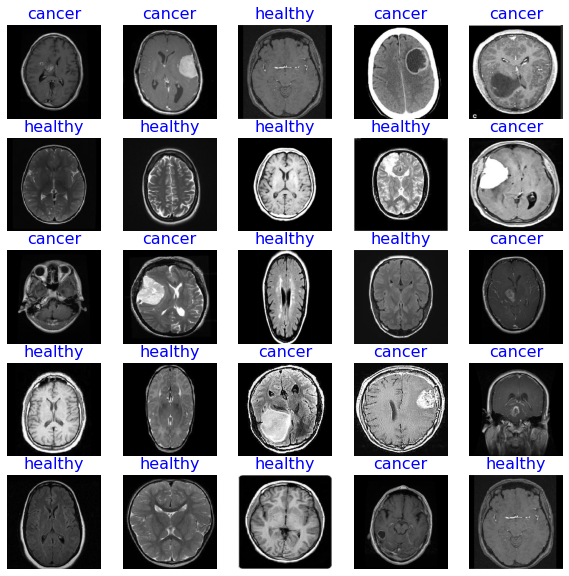

In [30]:
show_brain_images(train)

In [35]:
model=Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,2),strides=(1,1),activation='relu',padding='valid',input_shape=(244,244,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.32))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 242, 243, 32)      608       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 468512)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               59969664  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                

In [36]:
History=model.fit(train, validation_data=val, epochs=10, verbose=1)

Epoch 1/10
115/115 [==============================] - 152s 1s/step - loss: 1.8983 - accuracy: 0.6764 - val_loss: 0.4486 - val_accuracy: 0.8098
Epoch 2/10
115/115 [==============================] - 152s 1s/step - loss: 0.3863 - accuracy: 0.8234 - val_loss: 0.3188 - val_accuracy: 0.8620
Epoch 3/10
115/115 [==============================] - 100s 872ms/step - loss: 0.2392 - accuracy: 0.8856 - val_loss: 0.1730 - val_accuracy: 0.9315
Epoch 4/10
115/115 [==============================] - 109s 947ms/step - loss: 0.1666 - accuracy: 0.9209 - val_loss: 0.1531 - val_accuracy: 0.9380
Epoch 5/10
115/115 [==============================] - 146s 1s/step - loss: 0.1718 - accuracy: 0.9193 - val_loss: 0.1547 - val_accuracy: 0.9380
Epoch 6/10
115/115 [==============================] - 131s 1s/step - loss: 0.1075 - accuracy: 0.9481 - val_loss: 0.1406 - val_accuracy: 0.9533
Epoch 7/10
115/115 [==============================] - 94s 818ms/step - loss: 0.0885 - accuracy: 0.9514 - val_loss: 0.1272 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

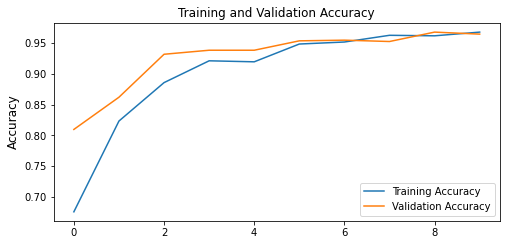

In [39]:
acc=History.history["accuracy"]
val_acc=History.history["val_accuracy"]

loss=History.history["loss"]
val_loss=History.history["val_loss"]

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")

plt.legend()
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

Text(0.5, 1.0, 'Training and Validation Accuracy')

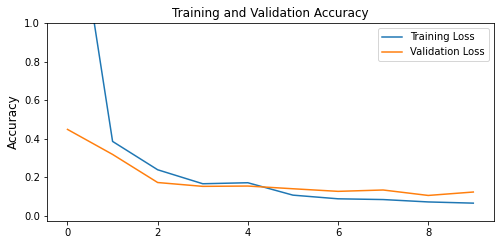

In [41]:
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)

plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.legend()
plt.ylim([min(plt.ylim()),1])
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training and Validation Accuracy", fontsize=12)

In [42]:
model.evaluate(test, verbose=1)

44/44 [==============================] - 8s 190ms/step - loss: 0.0855 - accuracy: 0.9754


[0.08554928749799728, 0.9753623008728027]

In [43]:
pred=model.predict(test)
pred=np.argmax(pred, axis=1)

labels=(train.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred2=[labels[k] for k in pred]

In [50]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
y_test=test_images.labels
print(classification_report(y_test,pred2))

              precision    recall  f1-score   support

      cancer       0.97      0.99      0.98       779
     healthy       0.99      0.96      0.97       601

    accuracy                           0.98      1380
   macro avg       0.98      0.97      0.97      1380
weighted avg       0.98      0.98      0.98      1380



In [51]:
print("Accuracy of the model:",accuracy_score(y_test, pred2)*100)

Accuracy of the model: 97.53623188405797


<AxesSubplot:>

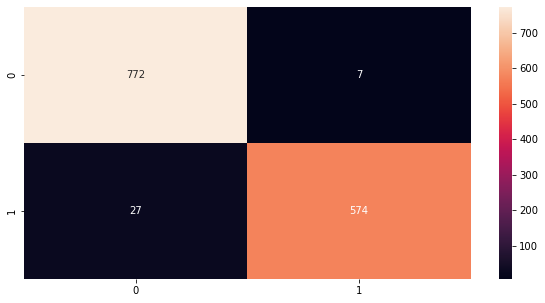

In [54]:
plt.figure(figsize = (10,5))
cm = confusion_matrix(y_test, pred2)
sns.heatmap(cm, annot=True, fmt = 'g')

In [60]:
#creating the model
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output

In [62]:
def img_pred(uploader):
    for name, file_info in uploader.value.items():
        img=Imagemopen(io.BytesIO(file_info['content']))
    opencvImage=cv.cvtColor(np.array(img), cv.COLOR_RGB2BGR)
    img=cv2.resize(opencvImage, (244,244))
    img = img.reshape(1,244,244,3)
    p=model.predict(img)
    p=np.argmax(p,axis=1)[0]
    
    if p==0:
        print('\tCancer')
    elif p==1:
        print('\tHealthy')
    else:
        p=='NOT SURE'

In [65]:
uploader = widgets.FileUpload()
uploader

FileUpload(value=(), description='Upload')

In [66]:
from PIL import Image

for name, file_info in uploader.value.items():
  img3 = Image.open(io.BytesIO(file_info['content']))
  img3.show(title=None, command=None)
  plt.imshow(img3)
  

button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])

AttributeError: 'tuple' object has no attribute 'items'